## CNN Feature Map Visualization

### Notebook & Packages

In [2]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-18 17:36:02.668379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 17:36:02.682623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 17:36:02.687110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 17:36:02.698188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.6.0

End checks and initialization.


I0000 00:00:1734543364.581589  842321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734543364.621140  842321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734543364.625179  842321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734543364.630659  842321 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout # General Layers
from keras.layers import RandomRotation, RandomFlip
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.initializers import glorot_uniform
from keras.utils import plot_model
# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff
from tifffile import imread

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

#### Import Data

In [4]:
images_dir = '/home/jupyter-luvogt/Final_Project_LR/IMC_images' 
metadata_dir = '/home/jupyter-luvogt/Final_Project_LR/metadata.csv'
# --- Load CSV and filter dataset ---
csv_file = metadata_dir
image_folder = images_dir

# Load the CSV
df = pd.read_csv(csv_file)

# Filter rows with NA in PDL1_score and convert to binary
df = df.dropna(subset=["PDL1_score"])
df["PDL1_score"] = df["PDL1_score"].astype(int)

# --- Train-Test-Validation Split ---
train_df, val_and_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df["PDL1_score"])
test_df, val_df = train_test_split(val_and_test_df, test_size=0.5, random_state=42, stratify=val_and_test_df["PDL1_score"])

# --- Load Images and Compute Mean and Standard Deviation ---

# Function to load a single image
def load_image(image_path):
    image = imread(image_path)  # Load all 46 channels
    return image.astype(np.float32)

# Initialize variables to accumulate sum and sum of squares
nr_images = 0
sum_images = np.zeros((46, 224, 224))
sum_squared_images = np.zeros((46, 224, 224))

# Accumulate the sum and sum of squares for the training dataset
for _, row in train_df.iterrows():
    image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
    image = load_image(image_path)
    nr_images += 1
    sum_images += image
    sum_squared_images += image ** 2

# Compute mean and standard deviation
mean = sum_images / nr_images
std = np.sqrt(sum_squared_images / nr_images - mean ** 2)

# --- Dataset Loading Function ---

def load_dataset(dataframe, image_folder, normalize = True): # augment = False
    images = []
    labels = []
    
    for _, row in dataframe.iterrows():
        image_path = os.path.join(image_folder, f"{row['sample_id']}.tiff")
        image = load_image(image_path)

        if normalize:
            image = (image - mean) / std

        # Convert to channels-last format (224, 224, 46)
        image = np.transpose(image, (1, 2, 0))

        # # Apply data augmentation if specified
        # if augment:
        #     # Random horizontal flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=2)
        #     # Random vertical flip
        #     if np.random.rand() > 0.5:
        #         image = np.flip(image, axis=1)

        images.append(image)
        labels.append(row["PDL1_score"])

    return np.array(images), np.array(labels)

### Create Datasets

In [25]:
# Training dataset without augmentation
X_train, y_train = load_dataset(train_df, image_folder, normalize = True)
# # Training dataset with data augmentation
# X_train_aug, y_train_aug = load_dataset(train_df, image_folder, augment=True)
# Validation dataset
X_val, y_val = load_dataset(val_df, image_folder, normalize = True)
# Test dataset
X_test, y_test = load_dataset(test_df, image_folder, normalize = True)

# # One Hot Encoding
# y_train= to_categorical(y_train)
# y_val= to_categorical(y_val)
# y_test = to_categorical(y_test)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (590, 224, 224, 46), y_train shape: (590,)
X_val shape: (197, 224, 224, 46), y_val shape: (197,)
X_test shape: (197, 224, 224, 46), y_test shape: (197,)


### Drop Channels

In [6]:
def drop_channels(image, channels_of_interest, channel_names):
        channel_names_new = [i for i in channel_names if i not in channels_of_interest]
        mask = np.zeros(image.shape[2], dtype=bool) # Error: np.zeros(image.shape[0], dtype=bool) and NOT np.zeros(image.shape[2], dtype=bool) (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        for i in channels_of_interest:
            mask[channel_names.index(i)] = True
        image = image[:, :, mask] # Error: image[mask, :, :] and not image[:, :, mask] ! (ONLY ERROR IF YOU DONT TRANSPOSE THE IMAGE, OTHERWISE OKEY)
        
        return image

In [7]:
channel_names_new = ["Gd160", "Eu153", "Gd155"]

panel_dir = '/home/jupyter-luvogt/Final_Project_LR/panel.csv' 
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

In [15]:
X_train_3 = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_train]
X_val_3 = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_val]
X_test_3 = [drop_channels(i, channel_names_new, list(channel_names.values())) for i in X_test]

In [16]:
X_train_3 = np.array(X_train_3)
X_val_3 = np.array(X_val_3)
X_test_3 = np.array(X_test_3)

### Flatten both 46 Channels and 3 Channels for t-SNE

In [21]:
# Define trivial function to unpack the images correctly
def unpack_flat(array):
    new_array = np.zeros(shape = (array.shape[0], array.shape[1]*array.shape[2]*array.shape[3]))
    for i,x  in enumerate(array):
        new_array[i, :] = x.flatten()
    return new_array

In [26]:
# All Channels
# X_train = unpack_flat(X_train)
# X_val = unpack_flat(X_val)
X_test = unpack_flat(X_test)

# 3 biological channels
# X_train_3 = unpack_flat(X_train_3)
# X_val_3 = unpack_flat(X_val_3)
X_test_3 = unpack_flat(X_test_3)

In [39]:
X_test_3.shape

(197, 150528)

In [41]:
print(X_test.shape)
print(X_test_3.shape)

(197, 2308096)
(197, 150528)


## t-SNE for 46 Channels

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(X_test)
tsne_3 = TSNE(n_components=2).fit_transform(X_test_3)

In [42]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
tx = tsne[:, 0]
ty = tsne[:, 1]

tx_3 = tsne_3[:, 0]
ty_3 = tsne_3[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

tx_3 = scale_to_01_range(tx_3)
ty_3 = scale_to_01_range(ty_3)

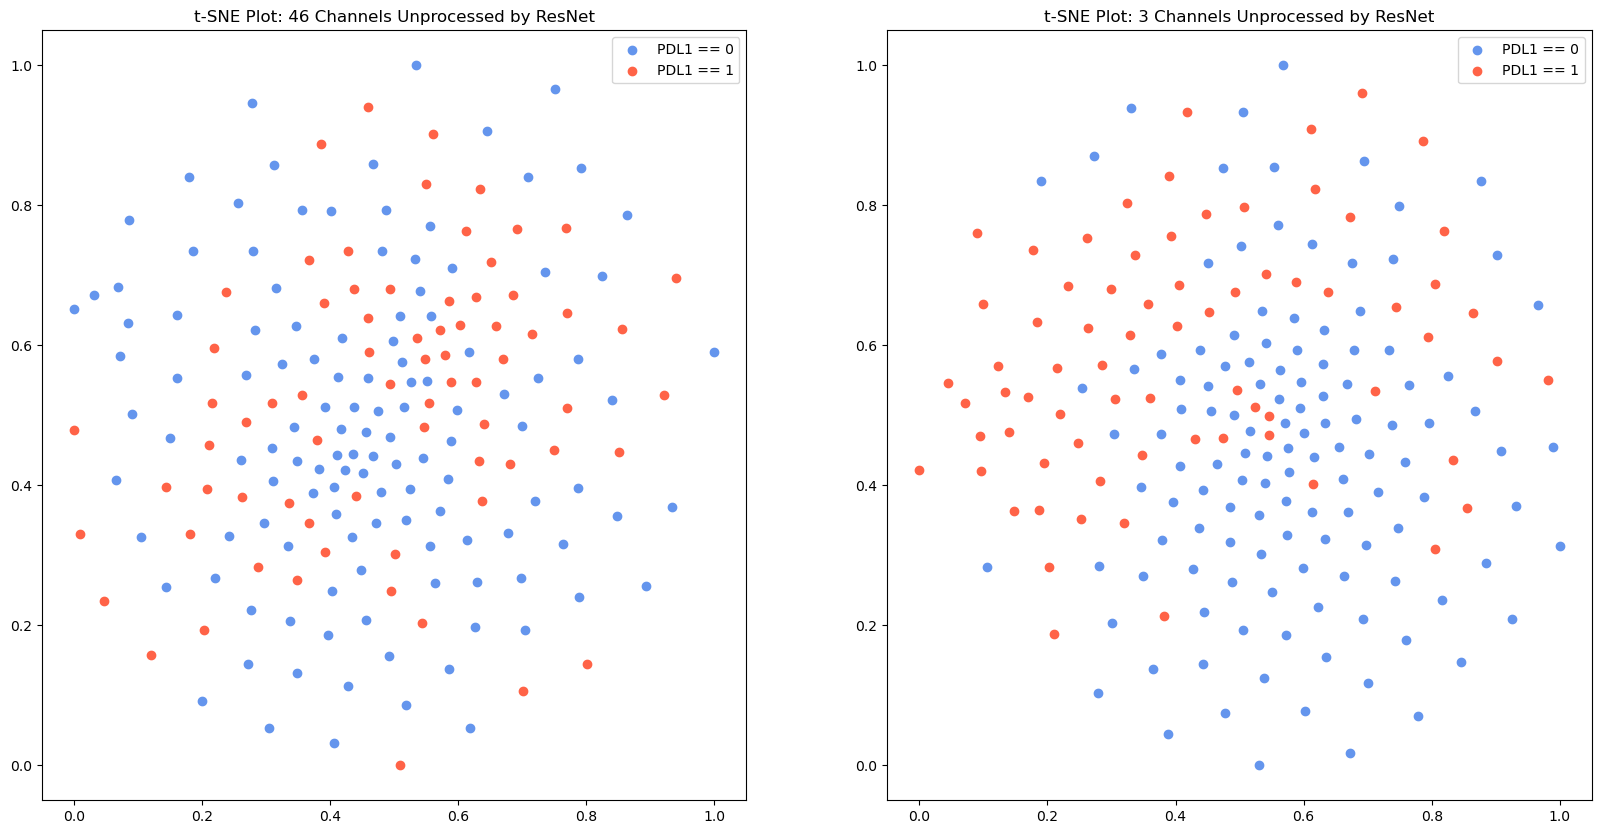

In [43]:
fig = plt.figure(figsize = [20, 10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
colors_per_class = [0, 1]
colors = ["cornflowerblue", "tomato"]

for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax1.scatter(current_tx, current_ty, c=color, label=label)
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(y_test) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx_3, indices)
    current_ty = np.take(ty_3, indices)
 
    # convert the class color to matplotlib format
    color = colors[label]
 
    # add a scatter plot with the corresponding color and label
    ax2.scatter(current_tx, current_ty, c=color, label=label)
# build a legend using the labels we set previously
ax1.legend(["PDL1 == 0", "PDL1 == 1"])
ax2.legend(["PDL1 == 0", "PDL1 == 1"])
ax1.set_title("t-SNE Plot: 46 Channels Unprocessed by ResNet")
ax2.set_title("t-SNE Plot: 3 Channels Unprocessed by ResNet")
 
# finally, show the plot
plt.show()